#### <b>Finetuning the model</b>

This notebook demonstrates how to finetune the model from its pretrained weights. For this, the following is required:
1. A csv/excel file that maps MOF name to its label of interest.
2. A folder of PXRDs for whatever set of MOFs you wish to finetune this model on.
3. A folder of precursor data for whatever set of MOFs you wish to finetune this model on.

In [1]:
import os
import pandas as pd
import numpy as np

# import main module
from xraypro.setGen import xraypro_loaders
import yaml
from xraypro.finetune_xraypro import FinetuneXRayPro, ScratchXRayPro

# importing some metrics
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

# suppressing warnings (not recommended)
import warnings
warnings.simplefilter('ignore')

import sys
print(f'Python version: {sys.version}')

/home/sartaaj/miniconda3/envs/xraypro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version: 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]


In [ ]:
df = pd.read_csv('data/arabg/full_ARABG_alldata.csv')
df = df.rename(columns = {'MOFname' : 'MOF'})

label = 'pure_uptake_methane_298.00_6500000'
df = df[['MOF', label]]
file_name = label.split(' ')[0]
df.to_csv(f'data/arabg/csv/{file_name}.csv', index = False)

df.head()

,MOF,pure_uptake_methane_298.00_6500000
0,acs_sym_7_mc_4__L_12__,13.712341
1,acs_sym_7_mc_4__L_12_FGB_2__,5.950109
2,acs_sym_7_mc_4__L_12_FGB_4__,3.882429
3,acs_sym_7_mc_4__L_12_FGCF_2__,5.299856
4,acs_sym_7_mc_4__L_12_FGCN_2__,9.845145


In [3]:
directory_to_pxrd = 'data/arabg/pxrd'
directory_to_precursors = 'data/arabg/precursors'
directory_to_csv = f'data/arabg/csv/{label}.csv'

In [10]:
yaml_path = os.path.join('xraypro', 'transformer_precursor', 'config_ft_transformer.yaml')
yaml_data = os.path.join('xraypro', 'transformer_precursor', 'config_data.yaml')

config = yaml.load(open(yaml_path, "r"), Loader=yaml.FullLoader)
config['dataloader']['randomSeed'] = 0

config_data = yaml.load(open(yaml_data, "r"), Loader = yaml.FullLoader)
config_data['path']['path_to_pxrd'] = f'./data/arabg/pxrd'
config_data['path']['path_to_precursor'] = f'./data/arabg/precursors'
config_data['model_save_path'] = f'./data/arabg/model_{file_name}_ft.pth'
config_data['path']['path_to_csv'] = f'./data/arabg/csv/{file_name}.csv'
config_data['test_ratio'] = 0.2
config_data['valid_ratio'] = 0.2
config_data['path']['label'] = label

SEEDS = [0, 1, 2]

In [ ]:
ft = FinetuneXRayPro(config, config_data)
ft.train()

Loaded pre-trained model with success.
/home/sartaaj/Desktop/XRDFormer_v2/xraypro_git/pretrained/cgcnn/model_t.pth
id_to_pxrd.pickle cannot be found... Processing PXRDs...
id_to_pxrd has been deposited to ./data/arabg/pxrd/id_to_pxrd.pickle
The random seed is:  0
Train size: 217, Validation size: 72, Test size: 72
Finished loading training, val and test sets!


In [ ]:
predictions_test, actual_test = ft.predict()

Epoch: 1, Loss: 50.240465799967446, Val Loss: 20.428462982177734, Val SRCC: 0.5217490842490842
Epoch: 2, Loss: 18.17747974395752, Val Loss: 13.998612403869629, Val SRCC: 0.6624084249084248
Epoch: 3, Loss: 13.25198237101237, Val Loss: 11.147567749023438, Val SRCC: 0.744642857142857
Epoch: 4, Loss: 11.989558855692545, Val Loss: 9.728827476501465, Val SRCC: 0.7598901098901097
Epoch: 5, Loss: 11.035138924916586, Val Loss: 9.389172554016113, Val SRCC: 0.8384615384615383
Epoch: 6, Loss: 9.0697922706604, Val Loss: 10.082895278930664, Val SRCC: 0.8708333333333331
Epoch: 7, Loss: 8.912009080251059, Val Loss: 8.751779556274414, Val SRCC: 0.8858516483516482
Epoch: 8, Loss: 7.899657567342122, Val Loss: 7.631743907928467, Val SRCC: 0.8935897435897435
Epoch: 9, Loss: 6.614079634348552, Val Loss: 6.021203994750977, Val SRCC: 0.9031135531135529
Epoch: 10, Loss: 7.176828543345134, Val Loss: 5.43199348449707, Val SRCC: 0.9071886446886446
Epoch: 11, Loss: 5.650029341379802, Val Loss: 4.970450401306152, V

Text(0.05, 0.75, 'MAE: 1.131\nMSE: 2.411\nRMSE: 1.553\nSRCC: 0.959')

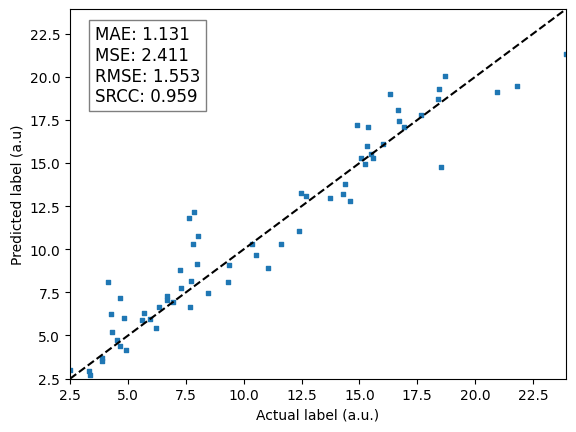

In [8]:
mae = mean_absolute_error(actual_test, predictions_test)
mse = mean_squared_error(actual_test, predictions_test)
rmse = np.sqrt(mse)
srcc, _ = spearmanr(actual_test, predictions_test)

plt.scatter(actual_test, predictions_test, s = 10, marker = 's')
plt.plot([min(actual_test), max(actual_test)], [min(actual_test), max(actual_test)], 'k', linestyle = '--')

plt.xlim([min(actual_test), max(actual_test)])
plt.ylim([min(actual_test), max(actual_test)])

plt.xlabel('Actual label (a.u.)')
plt.ylabel('Predicted label (a.u)')

metrics = f"MAE: {mae:.3f}\nMSE: {mse:.3f}\nRMSE: {rmse:.3f}\nSRCC: {srcc:.3f}"
plt.text(0.05, 0.75, metrics, fontsize = 12, transform = plt.gca().transAxes, bbox = dict(facecolor = 'white', alpha = 0.5))
